# Part 3b: Improve the model

Our goal in this section is to try out some of the techniques we have learned to improve the model quality.
That means several things can be done and it is up to you to try out on your own what works. If you prefer a more structured approach you can strictly follow the exercises. 

In the following you are provided with a new training set in the form of **features** $X$ and **labels** $Y$. It is constructed using a random timeshift and has mixed in background noise. You can select how many times to repeat the augmentation process with the **Nfold** variable below. Keep in mind that we cannot use too big of a number here, since the dataset still needs to fit into memory. Otherwise we would need to train directly with the generator. Despite being possible, it will take considerably longer.

### Load some libs and setup GPU usage

In [16]:
import tensorflow as tf

In [17]:
## Activate gpu usage if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:    
    try:  
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)
else:
    print('no gpus found!')

no gpus found!


In [18]:
%matplotlib inline

In [19]:
from config import *
import pandas as pd
from utility import keep_only_n_unknowns, pad_signal, augment_audio, get_callbacks
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [20]:
## Infer model size
n_max_frames     =  49  # leave this at 49 
n_output_neurons = 12

### Load the data

In [21]:
import numpy as np

In [22]:
X,Y = np.load("./data/X_train_data_augmented.npy"), np.load("./data/Y_train_data_augmented.npy")
val_data = np.load("./data/X_val_data.npy"), np.load("./data/Y_val_data.npy")
train_data = np.load("./data/X_train_data.npy"), np.load("./data/Y_train_data.npy")
Xn, Yn = np.load("./data/X_train_data_augmented_nfold.npy"), np.load("./data/Y_train_data_augmented_nfold.npy")

In [23]:
## Number of epochs to run the training for
n_epochs= 2

## Early stopping setting
patience= 25    

## Logging/debugging 
debugging_mode = False

## size of the batches used in training
batch_size = 32

#### TC-ResNet Architecture

In [24]:
## setup a new model architecture
from utility import ResBlock

def get_tc_resnet(n_max_frames, n_mfccs, n_output_neurons=12, dropout_rate=0.):

    T = n_max_frames 
    F = n_mfccs 

    n_channels = [16, 24, 32, 48]

    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(name='input_layer', shape=(T, F, 1)),
            layers.Reshape((T, 1, F), input_shape=(T, F, 1,)),
            layers.Conv2D(filters=n_channels[0], kernel_size=[3, 1], activation=None, use_bias=False,
                          padding='same'),
            layers.Dropout(dropout_rate),
            ResBlock(n=n_channels[1], s=2),
            layers.Dropout(dropout_rate),
            ResBlock(n=n_channels[1], s=1),
            layers.Dropout(dropout_rate),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(dropout_rate),
            layers.Dense(n_output_neurons, activation='softmax'),
        ]
    )
    
    return model

## Exercise
1. Take some time to review the network structure of the **TC resnet** above. How many parameters does the model have?

2. Do a baseline run with the train_data set. You can copy the important parts from above. What is the accuracy?

3. Lets try to further improve the accuracy by running with the new dataset. Be carefuful to adjust the steps_per_epoch part to the new length of the dataset. You might also want to scale down the number of epochs since the dataset effectively now contains **Nfold epochs**. Possible things to try out are:
    - Use the randomly augmented data  $Xn$, $Yn$. They are also 3 times as many data as $X$ and $Y$.
    - Use the set $X$,$Y$ which are shifted and with background noise but just one fold version of the baseline set
    - Add dropout by passing the dropout_rate variable to the tc-resnet
4. Discuss your results. Which measures helped?

<!-- 5. Bonus: download a model from [keras.applications](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) and train it for some epochs. -->

## Solution

### E1
- Reshape layer makes sure that we can apply the kernel over all frequencies simultaneously.
- Residual blocks $\rightarrow$ **resnet** like structure.
- Dropout layers are added.
- Global pooling reduces the size before the softmax layer.
- The softmax layer returns probabilities for the $12$ classes.

### E2 baseline: Fit with training set unaugmented 1fold

In [25]:
from tensorflow import keras

model = get_tc_resnet(n_max_frames, n_mfccs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()],
              run_eagerly=debugging_mode)

logging to:  ./output/2023_07_26_22_08_20/
Epoch 1/2
1162/1162 [==============================] - ETA: 0s - loss: 0.8208 - categorical_accuracy: 0.7476

2023-07-26 22:08:57.775270: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./output/2023_07_26_22_08_20/saved_models/assets


INFO:tensorflow:Assets written to: ./output/2023_07_26_22_08_20/saved_models/assets


1162/1162 [==============================] - 47s 37ms/step - loss: 0.8208 - categorical_accuracy: 0.7476 - val_loss: 0.4907 - val_categorical_accuracy: 0.8451
Epoch 2/2
1092/1162 [===========================>..] - ETA: 1s - loss: 0.4170 - categorical_accuracy: 0.8652WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2324 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: ./output/2023_07_26_22_08_20/saved_models/assets


INFO:tensorflow:Assets written to: ./output/2023_07_26_22_08_20/saved_models/assets


1162/1162 [==============================] - 38s 33ms/step - loss: 0.4169 - categorical_accuracy: 0.8652 - val_loss: 0.4617 - val_categorical_accuracy: 0.8482
max val val_categorical_accuracy 0.8481826186180115


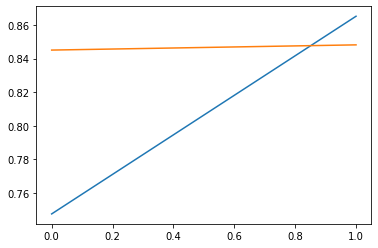

In [11]:
history = model.fit(x=train_data[0], y=train_data[1], 
                    steps_per_epoch=int(np.floor(len(train_data[0]) / batch_size)),
                    epochs=n_epochs, 
                    callbacks=get_callbacks(output_dir, val_data, model, patience=patience), 
                    validation_data=val_data, 
                    shuffle=False)

print('max val val_categorical_accuracy', np.max(history.history['val_categorical_accuracy']))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

### E3: Fit with training set augmented 1fold

In [12]:
model = get_tc_resnet(n_max_frames, n_mfccs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()],
              run_eagerly=debugging_mode)

logging to:  ./output/2023_07_26_22_09_46/
Epoch 1/2
1161/1162 [============================>.] - ETA: 0s - loss: 1.0391 - categorical_accuracy: 0.6735

INFO:tensorflow:Assets written to: ./output/2023_07_26_22_09_46/saved_models/assets


INFO:tensorflow:Assets written to: ./output/2023_07_26_22_09_46/saved_models/assets


1162/1162 [==============================] - 40s 32ms/step - loss: 1.0386 - categorical_accuracy: 0.6737 - val_loss: 0.4980 - val_categorical_accuracy: 0.8493
Epoch 2/2
1092/1162 [===========================>..] - ETA: 1s - loss: 0.5655 - categorical_accuracy: 0.8188WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2324 batches). You may need to use the repeat() function when building your dataset.


1162/1162 [==============================] - 31s 27ms/step - loss: 0.5653 - categorical_accuracy: 0.8189 - val_loss: 0.5115 - val_categorical_accuracy: 0.8358
max val val_categorical_accuracy 0.8492907881736755


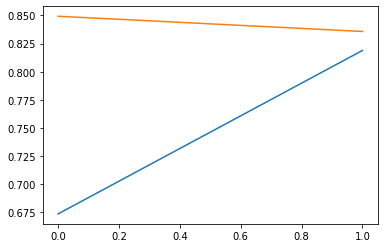

In [13]:
history = model.fit(x=X, y=Y, 
                    steps_per_epoch=int(np.floor(len(X) / batch_size)),
                    epochs=n_epochs, 
                    callbacks=get_callbacks(output_dir, val_data, model, patience=patience), 
                    validation_data=val_data, 
                    shuffle=False)
print('max val val_categorical_accuracy', np.max(history.history['val_categorical_accuracy']))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

### E3: Fit with nfold data augmentation

In [26]:
model = get_tc_resnet(n_max_frames, n_mfccs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()],
              run_eagerly=debugging_mode)

In [27]:
n_epochs_corrected = int(n_epochs / 2)

history = model.fit(x=Xn, y=Yn, 
                    steps_per_epoch=int(np.floor(len(Xn) / batch_size)),
                    epochs=n_epochs_corrected , 
                    callbacks=get_callbacks(output_dir, val_data, model, patience=patience), 
                    validation_data=val_data, 
                    shuffle=False)
print('max val val_categorical_accuracy', np.max(history.history['val_categorical_accuracy']))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

logging to:  ./output/2023_07_26_22_13_00/
 705/3492 [=====>........................] - ETA: 48s - loss: 1.2982 - categorical_accuracy: 0.6031

KeyboardInterrupt: 

### E3: Fit with nfold augmented + dropout

In [28]:
model = get_tc_resnet(n_max_frames, n_mfccs, dropout_rate=0.2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()],
              run_eagerly=debugging_mode)

In [29]:
n_epochs_corrected = int(n_epochs)

history = model.fit(x=Xn, y=Yn, 
                    steps_per_epoch=int(np.floor(len(Xn) / batch_size)),
                    epochs=n_epochs_corrected , 
                    callbacks=get_callbacks(output_dir, val_data, model, patience=patience), 
                    validation_data=val_data, 
                    shuffle=False)
print('max val val_categorical_accuracy', np.max(history.history['val_categorical_accuracy']))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

logging to:  ./output/2023_07_26_22_13_22/
Epoch 1/2
 249/3492 [=>............................] - ETA: 1:04 - loss: 2.2990 - categorical_accuracy: 0.2158

KeyboardInterrupt: 

### E4: Discussion
Sorted by accuracy:
- 1fold augmented set with timeshift and background noise $\rightarrow$ $91.8\%$ 
- Baseline with unaugmented training set $\rightarrow$ $92.4\%$ (Makes sense, since validation set is not augmented!)
- 3fold augmented $\rightarrow$ $93.8\%$
- 3fold augmented with dropout of $0.2$ $\rightarrow$ $94.5\%$

The difference in accuracy is roughly 3 percentage points. That is, with an already optimized structure for keyword spotting. It is a sizeable effect, which could have been even bigger when starting from a different model architecture. 

# Part 6: Train using other pretrained models - MobileNetV2

In this section we will use a predefined model **(MobileNetV2)** from [keras.applications](https://keras.io/api/applications/) that is meant for **image classification** and try it out for **keyword spotting**. The model can easily be downloaded via $tf.keras.applications$.

In [30]:
model = tf.keras.applications.MobileNetV2(
    input_shape=(49,40,1),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=12,
    classifier_activation="softmax",
)

In [31]:
model.summary()

Model: "mobilenetv2_1.00_49"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 49, 40, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 25, 20, 32)   288         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 25, 20, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 25, 20, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

## Exercise
1. Compile and train the model as done above.
2. Compare the results to our previous ones in terms of parameters and accuracy. What can we learn?

## Solution

### E1

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()],
              run_eagerly=debugging_mode)

In [34]:
n_epochs_corrected = int(n_epochs / 2)

history = model.fit(x=Xn, y=Yn, 
                    steps_per_epoch=int(np.floor(len(Xn) / batch_size)),
                    epochs=n_epochs_corrected , 
                    callbacks=get_callbacks(output_dir, val_data, model, patience=patience), 
                    validation_data=val_data, 
                    shuffle=False)
print('max val val_categorical_accuracy', np.max(history.history['val_categorical_accuracy']))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

logging to:  ./output/2023_07_26_22_13_48/
  10/3492 [..............................] - ETA: 27:14 - loss: 2.7799 - categorical_accuracy: 0.0667

KeyboardInterrupt: 

In [ ]:
print('max val val_categorical_accuracy', np.max(history.history['val_categorical_accuracy']))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

### E2

- Model has more parameters.
- Performance is similar.

What can we learn?
- Loading pre-defined bigger convolutional models is a very good way to start your training and get a baseline accuracy. However it might be necessary and rewarding to tailor the model architecture to your needs.